In [19]:
from collections import OrderedDict
import numpy as np
%matplotlib notebook
import matplotlib


import warnings;
with warnings.catch_warnings():
    warnings.simplefilter("ignore"); 
    import matplotlib.pyplot as plt
from skimage.transform import rescale




class Scribbler:
    
    def __init__(self, im, segment_names=None, title=None):
        
        self.im = im
        
        # create initial plot
        self.figure = plt.figure()
        self.ax = self.figure.add_subplot(111)
        plt.imshow(im, interpolation='none')
        plt.axis([0, im.shape[1], im.shape[0], 0])
        plt.axis('off')
        if title:
            self.figure.canvas.set_window_title(title)
    
        # disable default keybindings
        manager, canvas = self.figure.canvas.manager, self.figure.canvas  
        canvas.mpl_disconnect(manager.key_press_handler_id)
        
        # callbacks
        self.figure.canvas.mpl_connect('key_press_event', self.on_keypress)
        self.figure.canvas.mpl_connect('motion_notify_event', self.on_mouse_motion)
        self.figure.canvas.mpl_connect('button_press_event', self.on_mouse_down)
        self.figure.canvas.mpl_connect('button_release_event', self.on_mouse_up)
        
        
        # brush
        self.brush_radius = 5  # TODO: these should be fractions of image size
        self.min_radius = 5
        self.radius_increment = 10
        self.brush_color = 'r'
        self.brush = None

        # scribbles
        if not segment_names:
            segment_names = [str(num+1) for num in range(7)]
        self.scribble_colors = 'bgcmykw'  # FIXME: could run out of colors
        self.scribbles = OrderedDict()
        for name in segment_names:
            self.scribbles[name] = []
        self.active_scribble = self.scribbles[segment_names[0]]
        self.active_scribble_color = self.scribble_colors[0]
        self.mouse_is_down = False                                          
        self.num_patches = 0
        
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.ion()
        plt.show()
        #self.figure.canvas.start_event_loop(timeout=-1)                                                                   
    
        
    def on_mouse_up(self, event):
        self.mouse_is_down = False
        
        
    def on_mouse_down(self, event):
        self.mouse_is_down = True
        if event.inaxes!=self.ax: return
        
        center = event.xdata, event.ydata
        self.add_circle_to_scribble(center)
        self.redraw()
                                                   
    
    def on_mouse_motion(self, event):
        center = (event.xdata, event.ydata)
        
        # draw the bush circle
#         if self.brush:
#             self.brush.center = center
#         else:
#             self.brush = matplotlib.patches.Circle(center, 
#                                                     radius=self.brush_radius,
#                                                     edgecolor=self.brush_color,
#                                                     facecolor='none',
#                                                     zorder=1e6)  # always on top
#             self.ax.add_patch(self.brush)
#         self.redraw()
        
        # add to the scribble
        if self.mouse_is_down:
            self.add_circle_to_scribble(center)
        
        
    def on_keypress(self, event):
        if event.key in ['q', 'Q', 'escape']:
            self.quit_()
        elif event.key in ['=', 'super+=']:
            self.enlarge_brush()
        elif event.key in ['-', 'super+-']:
            self.shrink_brush()
        elif event.key == 'z':
            self.remove_circle_from_scribble()
#        elif event.key == 's':
#            self.save()
        elif event.key in [str(num+1) for num in range(len(self.scribbles))]:
            num = int(event.key) - 1
            name = self.scribbles.keys()[num]
            self.active_scribble = self.scribbles[name]
            self.active_scribble_color = self.scribble_colors[num]
                    
    
    def add_circle_to_scribble(self, center):
        ### TODO
        self.redraw()
        
    
    def remove_circle_from_scribble(self):
        if self.active_scribble:
            last_circle = self.active_scribble.pop()
            last_circle.remove()
            self.num_patches -= 1
            self.redraw()
            
            
    def enlarge_brush(self):
        self.brush_radius += self.radius_increment
        if self.brush:
            self.brush.radius = self.brush_radius    
            self.redraw()
        
        
    def shrink_brush(self):
        self.brush_radius -= self.radius_increment
        self.brush_radius = max([self.brush_radius, self.min_radius])
        if self.brush:
            self.brush.radius = self.brush_radius    
            self.redraw()

    
    def quit_(self):
        plt.close()
        self.figure.canvas.stop_event_loop()
        
        
    def redraw(self):
        self.figure.canvas.draw()
    

    def add_circle_to_mask(self, center, radius, mask):
        if not center[0] or not center[1]:
            return
        xx, yy = np.mgrid[:self.im.shape[0], :self.im.shape[1]]
        circle_mask = (xx - center[1]) ** 2 + (yy - center[0]) ** 2 <= radius**2
        mask[circle_mask] = 1
        
    
    def circles_to_mask(self, centers, radii):
        mask = np.zeros(self.im.shape[:2], dtype=bool)
        for center, radius in zip(centers, radii):
            self.add_circle_to_mask(center, radius, mask)
        return mask
        
    
    def get_scribble_masks(self):
        masks = {}
        for name, scribble in self.scribbles.iteritems():
            centers = [circle.center for circle in scribble]
            radii = [circle.radius for circle in scribble]
            if centers:
                masks[name] = self.circles_to_mask(centers, radii)
        return masks
        
    
    def get_scribble_pixels(self):
        scribble_masks = self.get_scribble_masks()
        return {name: self.im[mask] for name, mask in scribble_masks.iteritems()}

            

def color_hist(im, n_bins=64, colors='rgb'):
    range_ = (im.min(), im.max())
    r,g,b = map(np.squeeze, np.split(im[:-1],3,-1))
    plt.plot(np.histogram(r, n_bins, range_)[0], c=colors[0], linewidth=3)
    plt.plot(np.histogram(g, n_bins, range_)[0], c=colors[1], linewidth=3)
    plt.plot(np.histogram(b, n_bins, range_)[0], c=colors[2], linewidth=3)
    

    


/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


<IPython.core.display.Javascript object>


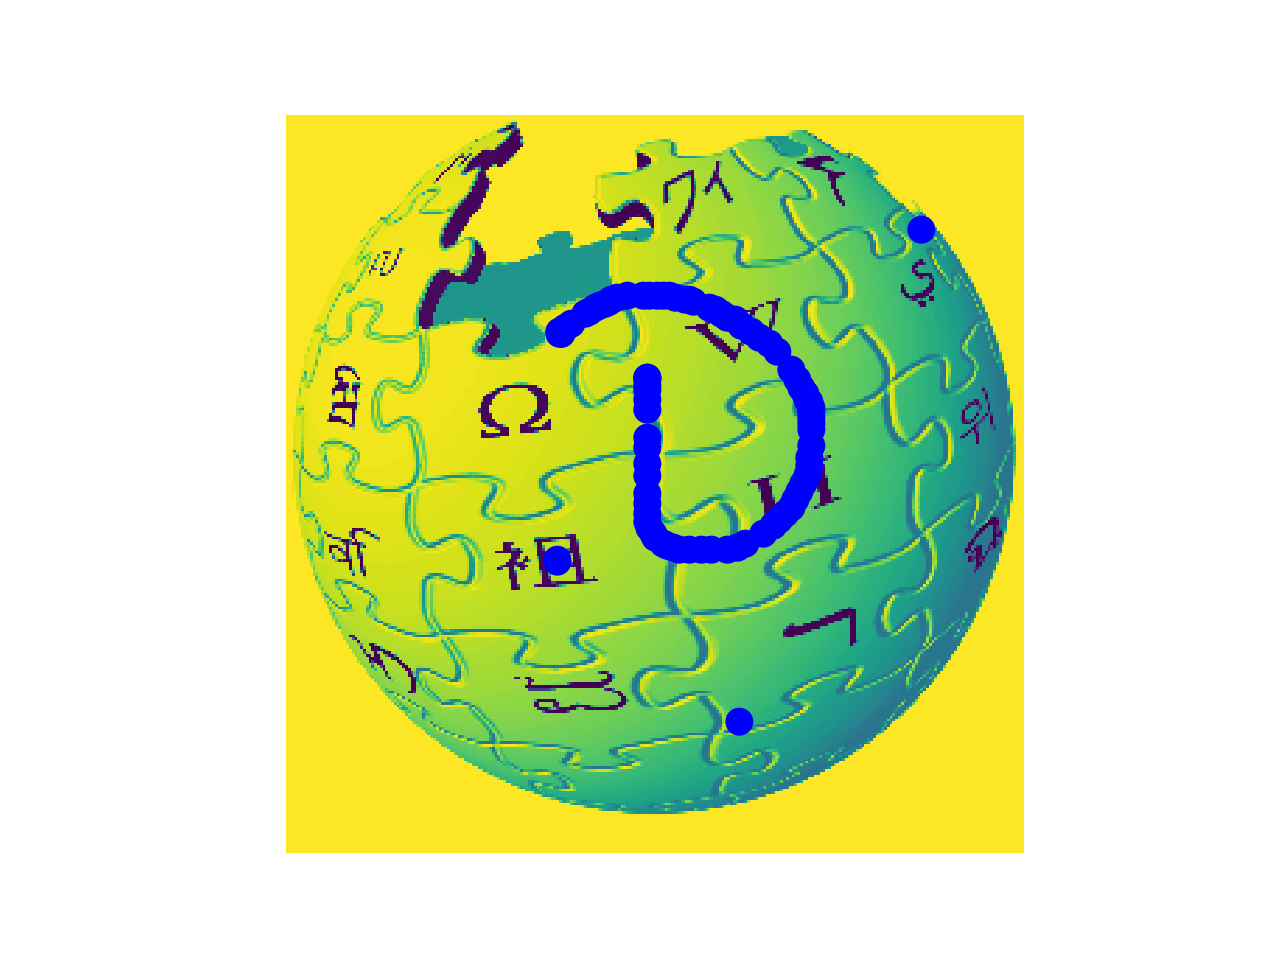

In [21]:

im = plt.imread("https://upload.wikimedia.org/wikipedia/commons/d/de/Wikipedia_Logo_1.0.png")
im = rescale(im, 0.25)


scribbler = Scribbler(im)





In [3]:
scribble_masks = scribbler.get_scribble_masks()
scribble_pixels = scribbler.get_scribble_pixels()
for name, pixels in scribble_pixels.iteritems():
    mask = scribble_masks[name]
    plt.figure()
    plt.subplot(211)
    plt.imshow(mask, cmap='gray')
    plt.title('Segment %s' % name)
    plt.subplot(212)
    color_hist(pixels)

NameError: name 'scribbler' is not defined